In [89]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt


**Make sure to set the correct filepath to the AlphaMissense dataset**


In [ ]:
df = pd.DataFrame(pd.read_csv('AlphaMissense_hg38.tsv', delimiter='\t', header=3))

In [90]:
df.head(5)

,#CHROM,POS,REF,ALT,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class
0,chr1,69094,G,T,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign
1,chr1,69094,G,C,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign
2,chr1,69094,G,A,hg38,Q8NH21,ENST00000335137.4,V2M,0.3296,likely_benign
3,chr1,69095,T,C,hg38,Q8NH21,ENST00000335137.4,V2A,0.2609,likely_benign
4,chr1,69095,T,A,hg38,Q8NH21,ENST00000335137.4,V2E,0.2922,likely_benign


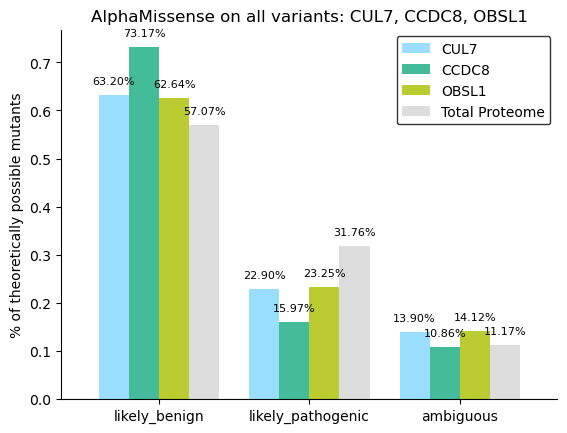

In [91]:
# 1) Determining AlphaMissense susceptibility of the 3M proteins

searchFilter = (df['uniprot_id'] == 'O75147') # OBSL1
OBSL1_counts = df[searchFilter]['am_class'].value_counts(normalize=1)

searchFilter = (df['uniprot_id'] == 'Q9H0W5') # CCDC8
CCDC8_counts = df[searchFilter]['am_class'].value_counts(normalize=1)

searchFilter = (df['uniprot_id'] == 'Q14999') # CUL7
CUL7_counts = df[searchFilter]['am_class'].value_counts(normalize=1)

all_counts = df['am_class'].value_counts(normalize=1) # all proteins

susceptibilityCounts = pd.DataFrame({
    'CUL7' : CUL7_counts,
    'CCDC8' : CCDC8_counts,
    'OBSL1' : OBSL1_counts,
    'Total Proteome' : all_counts,
})


# Plotting as a bar chart

colors = ['#99ddff', '#44bb99', '#bbcc33', '#dddddd']

ax = susceptibilityCounts.plot(kind='bar', position=0.5, width=0.8, color=colors)

# plt.xlabel('Pathogenicity')
plt.xlabel('')
plt.ylabel('% of theoretically possible mutants')
plt.title('AlphaMissense on all variants: CUL7, CCDC8, OBSL1')
plt.legend()

#plt.xticks(range(3), ['ambiguous', 'likely benign', 'likely pathogenic'])
plt.xticks(rotation=0)

plt.legend(fontsize=10, edgecolor='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# custom annotations
for bar in ax.patches:
    customHeight = f"{bar.get_height():.2%}"
    
    annotPos = (bar.get_x() + bar.get_width() / 2., bar.get_height())
    
    annotProperties = {
        'ha': 'center',     # alignment
        'va': 'center',     
        'xytext': (0, 10),  # offset
        'textcoords': 'offset points',  
        'fontsize': 8, 
    }
    
    ax.annotate(customHeight, annotPos, **annotProperties)


plt.show()

In [92]:
clinvarDf = pd.DataFrame(pd.read_csv('clinvar_result.csv', delimiter='\t')) # importing clinvar data
variantList = clinvarDf['Protein change'].to_list()
cleanVariantList = [] # empty list for storage of mutants found in the clinvar DataFrame 

# Processing Data from ClinVar txt export

for i in variantList: 
    if type(i) == str: 
        if i.find(',') == True:
            j = i.split(',')
            j = j.lstrip().rstrip().replace('*', 'A') # replace * mutations with mutations to Ala (Assume: Loss of Function)
            cleanVariantList.append(j)
        else: 
            i = i.rstrip().lstrip().replace('*', 'A')
            cleanVariantList.append(i)
    else: continue

cleanVariantList

# Filtering the DataFrame with reported Variants from ClinVar

filtered_df = df[df['protein_variant'].isin(cleanVariantList)]

In [93]:
filtered_df['uniprot_id'].value_counts()

uniprot_id
O75147    128
O15417     24
Q9UKN7     20
Q14896     20
Q9NRD8     19
         ... 
Q96CG3      1
Q8N8J7      1
Q9H5J4      1
P01133      1
Q01113      1
Name: count, Length: 14587, dtype: int64

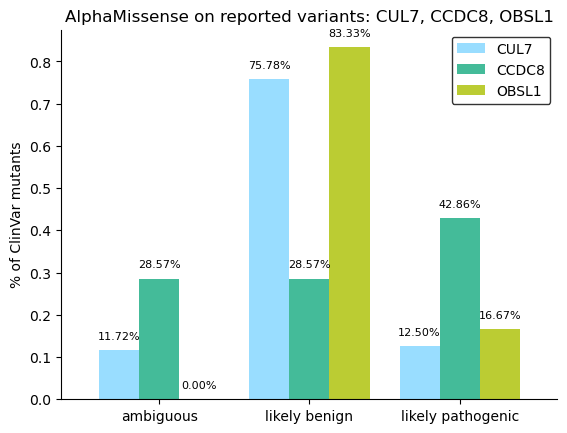

In [94]:
# Analysing AlphaMissense Predictions on clinically reported 3M syndrome associated mutants using the filtered dataframe

colors = ['#99ddff', '#44bb99', '#bbcc33']

CUL7 = filtered_df['uniprot_id'] == 'O75147'  # CUL7
CCDC8 = filtered_df['uniprot_id'] == 'Q9H0W5'  # CCDC8
OBSL1 = filtered_df['uniprot_id'] == 'Q14999'  # OBSL1

counts_CUL7 = filtered_df[CUL7]['am_class'].value_counts(normalize=1)
counts_CCDC8 = filtered_df[CCDC8]['am_class'].value_counts(normalize=1)
counts_OBSL1 = filtered_df[OBSL1]['am_class'].value_counts(normalize=1)

combined_counts = pd.DataFrame({
    'CUL7': counts_CUL7,
    'CCDC8': counts_CCDC8,
    'OBSL1': counts_OBSL1,
})

ax = combined_counts.plot(kind='bar', position=0.5, width=0.8, color=colors) # plotting all three value_counts next to another

# plt.xlabel('Pathogenicity')
plt.xlabel('')
plt.ylabel('% of ClinVar mutants')
plt.title('AlphaMissense on reported variants: CUL7, CCDC8, OBSL1')
plt.legend()

plt.xticks(range(3), ['ambiguous', 'likely benign', 'likely pathogenic'])
plt.xticks(rotation=0)

plt.legend(fontsize=10, edgecolor='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.show()


In [95]:
filtered_df.sort_values(by='am_pathogenicity').to_csv('out.csv', sep='\t') # exporting for further downstream analysis

filtered_df['am_class'].value_counts()

am_class
likely_benign        22592
likely_pathogenic    12723
ambiguous             4543
Name: count, dtype: int64

In [1]:
# for i in cleanVariantList: print(i)